In [1]:
import matplotlib
%matplotlib inline 
import gdal 
import numpy as np
import os
import pickle
from datetime import date
import time
import pandas as pd
import shapely
from shapely import geometry,ops
import glob
import sys
import geopandas as gp
import georasters as gr
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import csv

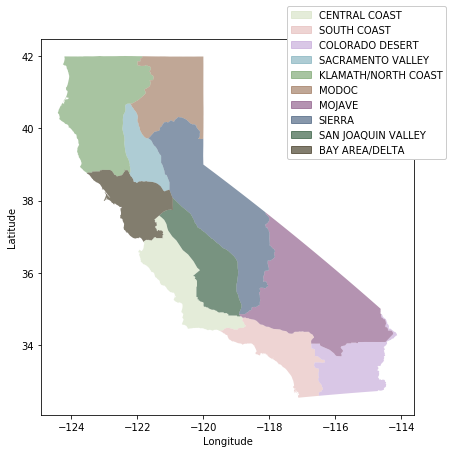

In [7]:
# get shapefiles 
filenames = glob.glob('./inaccreg/*.shp')

cols = sns.cubehelix_palette(n_colors=len((filenames)), rot=3)
f,ax = plt.subplots(figsize=(6,6))
areas = {}
hands = []
for i,f in enumerate(filenames):
    p = gp.read_file(f)
    geo = p.loc[p.geometry.area==p.geometry.area.max()]
    geo_wgs = geo.to_crs( {'init': 'epsg:4326'})
    patch = mpatches.Patch(edgecolor='k', color= cols[i], alpha=0.6, label=p.INACNAME.values[0])
    hands.append(patch)
    geo_wgs.plot(ax=ax, color=cols[i], alpha=0.6, label='_nolegend_')
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    areas[p.INACNAME.values[0].replace('/','')] = geo.geometry.values[0].area

leg = plt.legend(handles=hands, bbox_to_anchor=(1.1,1.1))
leg.get_frame().set_alpha(1.0)
plt.tight_layout()
plt.savefig('./plots/map_zones.png', bbox_inches='tight')

# Extract evapotranspiration for each bioregion

In [5]:
# empty list for dataframes generated by zonal stats
df_list = []
wy_total = {}

for i, f in enumerate(filenames):
    p = gp.read_file(f)
    name = p.INACNAME.values[0]
    geo = p.loc[p.geometry.area==p.geometry.area.max()].geometry.values[0]
    months = []
    et = []
    years = []
    for year in range(2001,2017):
        for month in range(1,13):
            months.append(month)
            years.append(year)
            year = str(year)
            month = str(month)
            if len(month)==1:
                month = '0'+ month
            
            rasterstring = "./data/monthly_ET/ET_%s-%s.tif"%(month,year)
            rast = gr.from_file(rasterstring)
            clipped_rast = rast.clip(geo)[0]
            clipped_rast.nodata_value = None
            et.append(clipped_rast.mean())
    tempdf = pd.DataFrame({'Monthly ET [mm]':et,'watershed':name, 'month':months, 'year':years})
    tempdf['Monthly ET [mm]'] = tempdf['Monthly ET [mm]'].astype(float)
    df_list.append(tempdf.copy())

df = pd.concat(df_list,axis=0)
df['date'] = ''
for i, row in df.iterrows():
    df.ix[i, 'date'] = pd.to_datetime(str(row.month) + '-' + str(row.year))
df = df.set_index('date')

# For each bioregion, plot annual ET total (July - June)

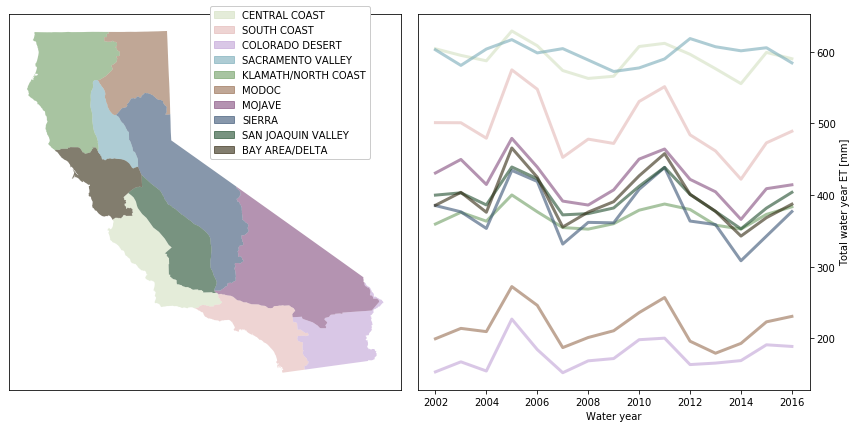

In [9]:
# get shapefiles 
filenames = glob.glob('./inaccreg/*.shp')
cols = sns.cubehelix_palette(n_colors=len((filenames)), rot=3)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6.0))
hands = []
for i,f in enumerate(filenames):
    p = gp.read_file(f)
    geo = p.loc[p.geometry.area==p.geometry.area.max()]
    patch = mpatches.Patch(edgecolor='k', color= cols[i], alpha=0.6, label=p.INACNAME.values[0])
    hands.append(patch)    
    geo.plot(ax=ax1, color=cols[i], alpha=0.6, label='_nolegend_')#, **{'edgecolor':cols[i]})

# Get water year ET totals
wys = {key:[] for key in list(set(df.watershed))}
for year in range(2001,2016):
    start_date = '7-1-' + str(year)
    end_date = '6-30-' + str(year+1)
    temp_df = df.loc[start_date:end_date]
    for key in wys.keys():
        wys[key].append(temp_df['Monthly ET [mm]'].loc[temp_df.watershed==key].sum())
        
wys = pd.DataFrame(wys, index=range(2002,2017))
for i, wa in enumerate(wys.keys()):
    ax2.plot(wys[wa], label=wa, linestyle='-', c=cols[i], lw=3, alpha=0.6)

xlabs = ax1.get_xticklabels()
xlabs = ['' for i in range(len(xlabs))]
ax1.set_xticklabels(xlabs)
ylabs = ax1.get_yticklabels()
ylabs = ['' for i in range(len(ylabs))]
ax1.set_yticklabels(ylabs)
leg = ax1.legend(loc='lower left', handles=hands, bbox_to_anchor=(0.5,0.6))
leg.get_frame().set_alpha(1.0)
ax1.tick_params('both', length=0)
ax2.set_ylabel('Total water year ET [mm]')
ax2.set_xlabel('Water year')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
fig.tight_layout()
plt.savefig('./plots/zones_and_map.pdf',bbox_inches='tight')

# For each bioregion, look at monthly variability in ET totals

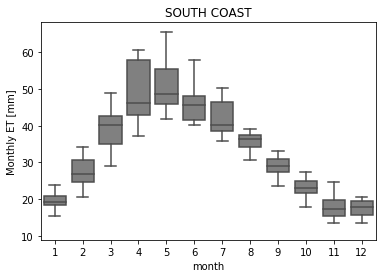

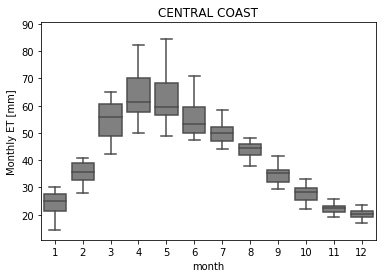

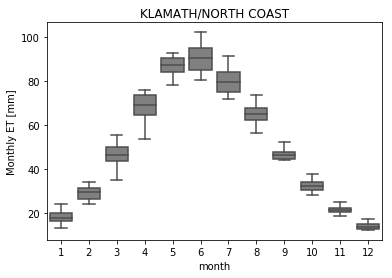

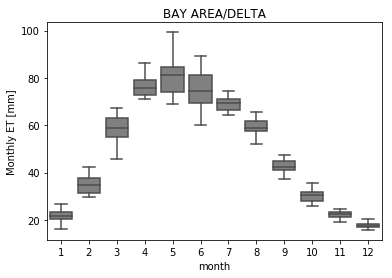

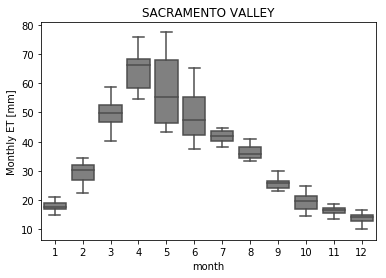

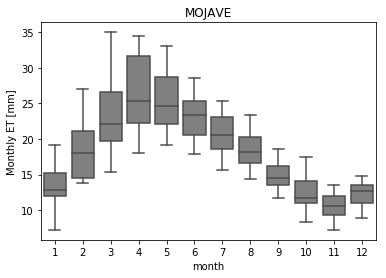

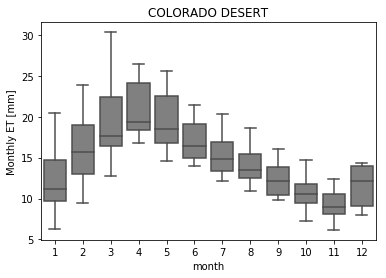

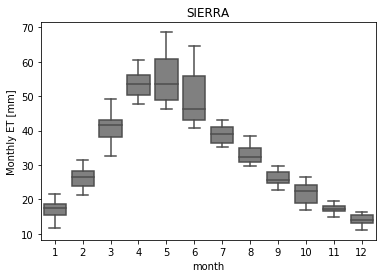

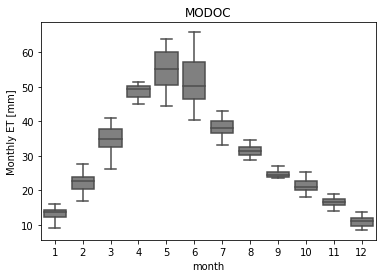

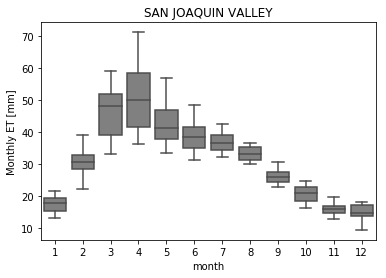

In [10]:
# plt.figure(figsize=(20,10))
for watershed in list(set(df.watershed.values)):
    tempdf = df.loc[df.watershed==watershed]
    plt.figure()
    sns.boxplot(x='month', y='Monthly ET [mm]',data=tempdf, color='grey', fliersize=0)
    plt.title(watershed)
    plt.savefig('./plots/zones_monthly/' + watershed.replace('/',' ') + '.pdf')

# Save data in .csv files

In [11]:
dflist = []
areas = {}
for d in df.groupby('watershed'):
    dtemp = d[1]
    name = list(set(d[1].watershed.values))[0]
    dtemp[name + '[mm]'] = dtemp['Monthly ET [mm]'].values
    dtemp = dtemp[[name + '[mm]']]
    dflist.append(dtemp)
    

dfupdate = pd.concat(dflist, axis=1)
dfupdate.to_csv('/Users/daviddralle/Desktop/monthly.csv')
wys.to_csv('./data/wys.csv')
with open('./data/areas.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in areas.items():
       writer.writerow([key, value])
